In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
ais_learners = pd.read_pickle('ROT-HAM_learners_60min.pkl')
ais_learners.head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,remainingMins,dist_to_end,hour_of_day,weekday,day_of_month,month
0,1000226,2016-06-15 14:00:00,369.0,51.0,13.8,51.970000,4.033333,5.200000,112.633333,112.000000,1493.000000,564.248455,14.0,2.0,15.0,6.0
1,1000226,2016-06-15 15:00:00,369.0,51.0,13.8,51.973830,4.046596,9.325532,196.780851,196.914894,1467.595745,564.496867,15.0,2.0,15.0,6.0
2,1000226,2016-06-15 16:00:00,369.0,51.0,13.8,52.134250,3.888500,12.945000,256.532500,345.275000,1395.650000,544.069639,16.0,2.0,15.0,6.0
3,1000226,2016-06-15 17:00:00,369.0,51.0,13.8,52.328793,3.868621,13.075862,153.406897,152.448276,1342.017241,528.601126,17.0,2.0,15.0,6.0
4,1000226,2016-06-15 18:00:00,369.0,51.0,13.8,52.530930,3.936512,12.574419,24.613953,23.418605,1283.046512,470.228412,18.0,2.0,15.0,6.0


In [3]:
X = ais_learners[['Latitude', 'Longitude', 'SOG']]
y = ais_learners['remainingMins']

In [4]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = ais_learners['TripID']))

In [5]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [6]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin_params = dict(normalize = [True, False])
lin_grid = GridSearchCV(lin, lin_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error')
lin_grid.fit(X, y)

pd.DataFrame(lin_grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_normalize,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0054,0.0007,-98.513629,-98.479368,True,{u'normalize': True},2,-89.0317,-99.480228,-116.847568,...,-94.517858,-99.026987,-97.181252,-98.585377,-91.596318,-99.315169,0.006248,0.000458,8.116349,1.00834
1,0.0032,0.0004,-98.513629,-98.479368,False,{u'normalize': False},1,-89.0317,-99.480228,-116.847568,...,-94.517858,-99.026987,-97.181252,-98.585377,-91.596318,-99.315169,0.000400,0.000490,8.116349,1.00834


In [7]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_params = dict(n_neighbors = range(1, 50), weights = ['uniform', 'distance'])
knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
knn_rand.fit(X, y)

pd.DataFrame(knn_rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0253,0.0241,-77.954070,-75.117667,31,uniform,"{u'n_neighbors': 31, u'weights': u'uniform'}",3,-68.011759,-76.434053,...,-71.593967,-75.730704,-74.807333,-75.599164,-77.120513,-75.466832,0.002648,0.003562,8.423268,1.055509
1,0.0239,0.0263,-78.182234,-75.815824,40,uniform,"{u'n_neighbors': 40, u'weights': u'uniform'}",7,-67.978344,-77.204176,...,-71.229903,-76.544422,-74.958458,-76.226726,-77.681227,-76.019795,0.003807,0.003226,8.600686,1.070194
2,0.0262,0.0230,-77.992781,-74.891508,28,uniform,"{u'n_neighbors': 28, u'weights': u'uniform'}",4,-68.369259,-76.194305,...,-71.586983,-75.538963,-75.031286,-75.314792,-76.710769,-75.188338,0.005618,0.003317,8.305440,1.065289
3,0.0282,0.0150,-79.868875,-70.975834,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",10,-72.058644,-72.134872,...,-74.407036,-71.449287,-78.218726,-71.221305,-77.341331,-71.554384,0.005250,0.002966,7.806097,1.077616
4,0.0254,0.0204,-78.048590,-74.599251,25,uniform,"{u'n_neighbors': 25, u'weights': u'uniform'}",5,-68.318790,-75.897698,...,-71.429574,-75.258159,-75.516346,-75.023775,-76.816251,-74.918917,0.003955,0.002417,8.298145,1.066447
5,0.0255,0.0329,-78.398609,-76.363959,49,uniform,"{u'n_neighbors': 49, u'weights': u'uniform'}",8,-68.279332,-77.790386,...,-71.377488,-77.062100,-74.780206,-76.846066,-78.082189,-76.575610,0.004945,0.002663,8.620181,1.093266
6,0.0292,0.0201,-78.166082,-73.501249,18,uniform,"{u'n_neighbors': 18, u'weights': u'uniform'}",6,-68.473209,-74.801405,...,-72.488436,-74.060885,-75.836858,-73.933674,-76.944524,-73.758973,0.000980,0.000539,8.161764,1.062651
7,0.0293,0.0201,-72.604905,-0.017734,19,distance,"{u'n_neighbors': 19, u'weights': u'distance'}",2,-64.371211,-0.022160,...,-67.600180,-0.022181,-74.196493,-0.022159,-66.188058,-0.022159,0.002722,0.001300,8.686622,0.008867
8,0.0291,0.0169,-79.121752,-72.267356,12,uniform,"{u'n_neighbors': 12, u'weights': u'uniform'}",9,-70.583037,-73.488418,...,-73.760087,-72.717857,-77.606090,-72.583687,-76.793591,-72.867607,0.000831,0.000700,8.108829,1.060068
9,0.0289,0.0337,-71.881417,-0.017734,45,distance,"{u'n_neighbors': 45, u'weights': u'distance'}",1,-63.391820,-0.022160,...,-66.230221,-0.022181,-72.427627,-0.022159,-65.924843,-0.022159,0.002385,0.000781,8.973088,0.008867


In [8]:
knn_best = KNeighborsRegressor(n_neighbors = 41, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(X_test)

In [9]:
knn_predicts_diffs = knn_predicts - y_test

In [10]:
knn_predicts_frame = pd.DataFrame({'correct': y_test, 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

count    1568.000000
mean       63.361523
std        86.061682
min         0.000000
25%         9.017876
50%        32.064716
75%        83.196404
max       831.782143
Name: abs_error, dtype: float64

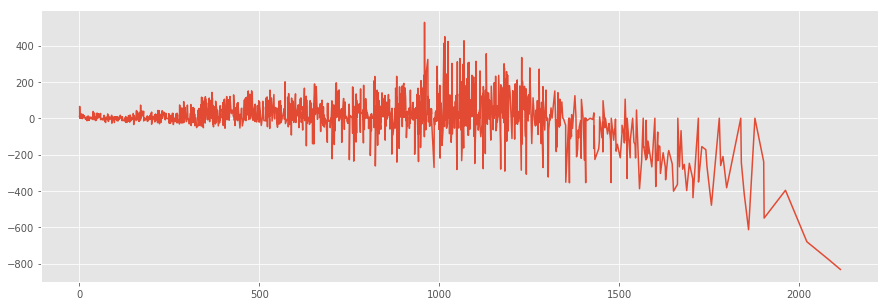

In [11]:
plt.figure(figsize = (15, 5))
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])

In [12]:
from sklearn.ensemble import RandomForestRegressor

rfo = RandomForestRegressor()
rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
rfo_rand.fit(X, y)

pd.DataFrame(rfo_rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.1692,0.0020,-81.115179,-79.221834,5,6,"{u'n_estimators': 6, u'max_depth': 5}",7,-72.266818,-80.490903,...,-74.412171,-80.025512,-78.318186,-79.400920,-81.240257,-79.363442,0.002441,0.000000e+00,8.379149,1.015525
1,0.1209,0.0021,-84.948456,-50.657922,14,2,"{u'n_estimators': 2, u'max_depth': 14}",9,-79.430810,-51.817051,...,-81.497650,-51.626771,-85.046600,-50.016036,-82.806791,-51.821388,0.006488,3.000021e-04,7.447374,1.051734
2,0.4017,0.0052,-78.213079,-50.587758,13,7,"{u'n_estimators': 7, u'max_depth': 13}",3,-69.675041,-51.470325,...,-74.410053,-50.958022,-79.029206,-50.544062,-75.593900,-51.072176,0.002759,4.000187e-04,7.749084,0.808516
3,0.2345,0.0037,-79.943897,-51.734939,13,4,"{u'n_estimators': 4, u'max_depth': 13}",5,-71.755807,-52.618359,...,-76.289500,-52.122593,-77.577602,-52.377440,-77.129933,-52.010080,0.010651,4.582920e-04,7.515899,0.845855
4,0.0978,0.0018,-78.386191,-75.433457,6,3,"{u'n_estimators': 3, u'max_depth': 6}",4,-69.259089,-76.926589,...,-70.746354,-76.165470,-75.249564,-75.751489,-78.068637,-74.997625,0.001720,3.999949e-04,8.386540,1.057747
5,0.1099,0.0020,-82.034653,-57.901516,12,2,"{u'n_estimators': 2, u'max_depth': 12}",8,-73.995103,-58.782569,...,-79.679699,-58.370334,-79.972556,-57.568745,-78.505280,-59.300335,0.002166,1.168008e-07,7.460301,1.005946
6,0.2269,0.0021,-77.111438,-74.564743,6,7,"{u'n_estimators': 7, u'max_depth': 6}",2,-68.489614,-76.190599,...,-69.770642,-75.081118,-74.207187,-74.915676,-77.154703,-74.629542,0.001972,5.385306e-04,8.535040,1.004431
7,0.0554,0.0016,-89.365507,-61.360903,12,1,"{u'n_estimators': 1, u'max_depth': 12}",10,-79.295213,-63.583987,...,-87.460075,-61.749596,-85.607350,-61.646105,-88.200068,-62.196176,0.002059,4.899403e-04,7.337057,1.204988
8,0.0385,0.0014,-80.181941,-76.177262,7,1,"{u'n_estimators': 1, u'max_depth': 7}",6,-73.376352,-77.967554,...,-76.689614,-77.669080,-76.991781,-76.214079,-80.320368,-76.546169,0.000671,4.898333e-04,7.592118,1.377345
9,0.3021,0.0035,-76.043350,-65.781573,9,7,"{u'n_estimators': 7, u'max_depth': 9}",1,-67.026200,-66.971260,...,-70.510080,-66.192788,-74.218192,-66.250197,-76.401212,-66.195629,0.002914,4.999876e-04,8.085767,0.970258


In [13]:
from sklearn.svm import SVR
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X, y) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
clf_predicts= clf.predict(X_test)
clf_predicts_diffs = clf_predicts - y_test

In [15]:
clf_predicts_frame = pd.DataFrame({'correct': y_test, 'clf_predicted': clf_predicts, 'diff': clf_predicts_diffs})
clf_predicts_frame['abs_error'] = clf_predicts_frame['diff'].transform(lambda x: abs(x))
clf_predicts_frame = clf_predicts_frame.sort_values('correct')
clf_predicts_frame['abs_error'].describe()

count    1568.000000
mean       99.757461
std       134.853418
min         0.072063
25%        23.211061
50%        52.068253
75%       114.490283
max      1163.434433
Name: abs_error, dtype: float64

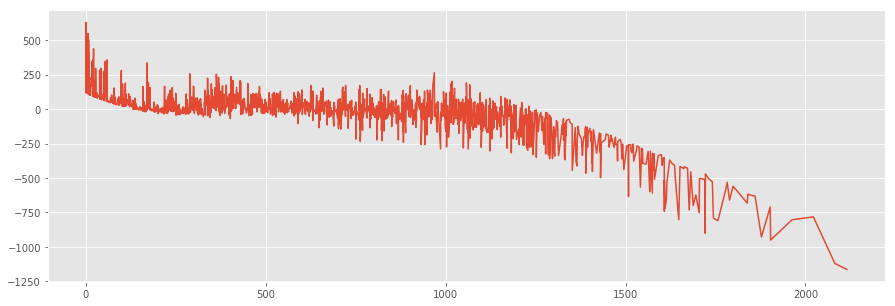

In [16]:
plt.figure(figsize = (15, 5))
plt.plot(clf_predicts_frame['correct'], clf_predicts_frame['diff'])

In [17]:
# need to test different parameters

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(7),max_iter=1000)
mlp.fit(X_train,y_train)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [18]:
ann_predicts= mlp.predict(X_test)
ann_predicts_diffs = ann_predicts - y_test
ann_predicts_frame = pd.DataFrame({'correct': y_test, 'ann_predicted': ann_predicts, 'diff': ann_predicts_diffs})
ann_predicts_frame['abs_error'] = ann_predicts_frame['diff'].transform(lambda x: abs(x))
ann_predicts_frame = ann_predicts_frame.sort_values('correct')
ann_predicts_frame['abs_error'].describe()

count    1568.000000
mean       93.892056
std        93.122930
min         0.101066
25%        33.002462
50%        66.053889
75%       121.779962
max       747.683507
Name: abs_error, dtype: float64

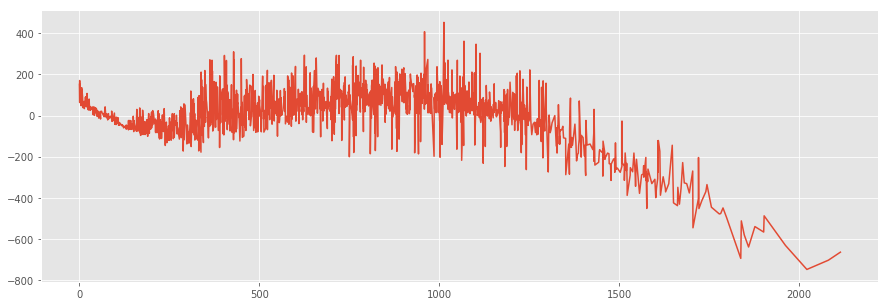

In [19]:
plt.figure(figsize = (15, 5))
plt.plot(ann_predicts_frame['correct'], ann_predicts_frame['diff'])